# Progetto Data and Web Mining 2020
### Ferrari Simone, Trolese Giulio

## Introduzione
Il progetto di quest’anno si basa su una **competizione Kaggle**, in particolare la **TMDB Box Office Prediction**.  
Ci vengono forniti dati su oltre 7000 film del passato presi dal **The Movie Database** con lo scopo di predirre il loro incasso. 

## Fase preliminare
Come prima cosa, dobbiamo preparare l'ambiente di lavoro. 
In particolare, eseguiamo:
- Il caricamento delle librerie
- La lettura dei dati

Inoltre, di seguito sono raccolte tutte le funzioni di uso generale.

### Caricamento delle librerie

In [1]:
import pandas as pd    # Pandas
import numpy as np     # Numpy

from sklearn.model_selection import train_test_split    # Splitting dataframe in Train / Test
from sklearn.decomposition import PCA                   # One Hot Encoding delle featuers
from sklearn.preprocessing import MultiLabelBinarizer   # 
from sklearn.metrics import accuracy_score              # Calcolo dell'accuracy 
from sklearn import tree                                # Modelli con alberi


import matplotlib.pyplot as plt                         # Creare plot
import seaborn as sns                                   # Creare plot
from collections import Counter                         # Contare le frequenze
import json                                             
import ast                                              # Convertire stringa in dizionario

### Funzioni utili utilizzate in seguito

In [2]:
# Colonne del dataframe che sono in formato stringa e devono essere convertite in dizionari
columnsToChange = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# Funzione che, preso un dataframe, lo maneggia e cambia le columnsToChange da stringhe a liste di dizionari
def stringToDictionary(dataFrame): 
    for column in columnsToChange:                                 # per ogni colonna indicata in columnsToChange
        dataFrame[column] = dataFrame[column].apply(               # Modifica la colonna come segue 
            lambda x: {} if pd.isna(x) else ast.literal_eval(x))   # Dizionario vuoto se l'elemento è NaN, altrimenti converte la stringa
    return dataFrame                                               # Ritorna il dataframe modificato

In [3]:
# Funzione che, presa una lista, ritorna una nuova lista contenente solo l'elemento name di ogni elemento nella colonna selezionata
def convert(in_list):
    output = []                       # Crea una lista vuota
    for elem in in_list:              # Per ogni elemento nella colonna
        output.append(elem["name"])   # Inserisce, in ordine, solo il name degli elementi presenti nella colonna
    return output                     # Ritorna la nuova lista

In [4]:
# Funzione che prende i valori di una colonna e li ritorna in una lista
def values_to_list(column, dataset):
    values = []                      # Lista vuota
    for l in dataset[column]:        # Per ogni lista conenuta nella colonna
        for elem in l:               # Per ogni elemento nella lista 
            values.append(elem)      # Inserisce l'elemento nella lista di ritorno
    return values                    # Ritorna la lista

### Lettura dei dati

In [5]:
# lettura del file train.csv
train = pd.read_csv("train.csv")

In [6]:
# Conversione delle colonne di tipo String in colonne di tipo Lista di Dizionario
train = stringToDictionary(train)

## Prima analisi del dataframe

Di seguito andremo ad **analizzare nel suo insieme il dataframe**, valutando **quali features possono essere utili** per il nostro scopo e quali, invece, possono essere rimosse. 

In [7]:
pd.set_option('display.max_columns', None) # Visualizza tutte le colonne del dataframe
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


**Osservazioni**: 
- Il dataframe compende 23 colonne (features), di cui alcune sembrano poco utili ano nostro scopo... successivamente approfondiremo. 
- Alcune features sono dati strutturati, comprendendo più informazioni all'interno della stessa colonna. Esempi sono `belongs to collection`, `genres`, ...

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

**Osservazioni**: 
- Alcune features hanno valori nulli: sarà materia di successive indagini. 

In [9]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,3000,3.000000e+03,3000,946,3000,3000,3000,2992,3000.000000,2999,3000,3000,3000,2998.000000,3000,3000,2403,3000,3000,3000,3000,3.000000e+03
unique,NaN,423,NaN,873,941,3000,36,2975,2992,NaN,2999,2384,322,2398,NaN,402,2,2400,2969,2649,2976,2985,NaN
top,NaN,{},NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0102798,en,The Gift,The mysterious murder of a US senator bearing ...,NaN,/oKj3DNThu3525pox53lxT9RG0F5.jpg,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Lolita,{},{},{},NaN
freq,NaN,2396,NaN,266,4,1,2575,2,1,NaN,1,156,1752,5,NaN,1817,2996,3,2,276,13,16,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


**Osservazioni**: 
- Alcuni valori sono sospetti, ad esempio: 
    - Il minimo `budget` è pari a 0... ma un film può avere budget 0? Poco probabile.
    - Il minimo di `runtime` è pari, nuovamente, a 0... anche in questo caso, è poco probabile, in quanto un film sicuramente dura più di 0 minuti!
    - Ha senso una `revenue` pari ad 1? Non troppo...
- Osserviamo che `status` ha solo due possibili valori
- Si osserva invece che `id` e `imdb_id` hanno valori univoci

## Manipolazione del dataframe

Dalle **analisi** eseguite ai punti **precedenti**, **abbiamo appreso** le seguenti informazioni:
- Abbiamo features che, molto probabilemnte, sono poco utili ai nosti scopi
- Abbiamo features strutturate che si potrebbero semplificare

Procediamo, quindi, manipolando i dati in modo da renderli più maneggevoli e corretti.

In [10]:
# Rinomina della colonna Keywords, per puri motivi di coerenza con uso di maiuscole. 
train.rename(columns={'Keywords': 'keywords'}, inplace=True)

In [11]:
# Cast del budget e della revenue in float
train.budget = train.budget.astype(float)
train.revenue = train.revenue.astype(float)

### Rimozione delle features poco utili

#### ID e IMDB_ID
Come detto, `id` e `imdb_id` hanno **valori univoci**, per cui possono essere rimossi in quanto non hanno rilevanza nella predizione. 

In [12]:
# Rimozione delle colonne id e imdb_id dal dataframe train
train.drop(['id','imdb_id'], axis='columns', inplace=True)

#### Titoli dei film
Gli `original_title` e `title`, nella maggior parte dei casi, sono **valori univoci** (`2975/3000 e 2969/3000`), mentre quei **pochi titoli duplicati** sono molto probabilmente **incorrelati** tra di loro.  
Possiamo quindi rimuoverli dal nostro dataframe.  

In [13]:
# Rimozione delle colonne original_title e title dal dataframe train
train.drop(labels=['original_title','title'], axis='columns', inplace=True)

#### Homepage, PosterPath e Status
Le `homepage` e i `poster_path` risultano essere features da cui è **difficile estrapolare informazioni utili**. Possiamo quindi rimuoverle. 

In [14]:
# Rimozione delle colonne homepage, poster_path e status dal dataframe train
train.drop(labels=['homepage','poster_path', 'status'], axis='columns', inplace=True)

#### Lingua originale
L'`original_language` la riteniamo **poco utile** ai fini di predirre la revenue, in quanto sono molto più d'interesse le lingue in cui un film è stato tradotto: contenute in `spoken_languages`

In [15]:
# Rimozione della colonna original_language dal dataframe train
train.drop(labels=['original_language'], axis='columns', inplace=True)

#### Overview e Tagline
Le features `overview` e `tagline` sono di tipo testuale e sono **complesse da analizzare**.  
Per ora le rimuoviamo, in quanto, per i nostri scopi, l'insieme delle `keywords` sicuramente ci può essere di **sufficiente** aiuto. 

In [16]:
# Rimozione delle colonne overview e tagline dal dataframe train
train.drop(labels=['overview', 'tagline'], axis='columns', inplace=True)

#### Cast & Crew
Le features `cast` e `crew` sono features che, *per il momento*, ignoreremo.  
Le analizzeremo nel seguito. 

In [17]:
# Rimozione delle colonne cast e crew dal dataframe train
train_with_cast_crew = train # Salvo un backup per poterlo utilizzare successivamente
train.drop(labels=["cast", "crew"], axis='columns', inplace=True)

#### Rivalutare il dataframe
Arrivati a questo punto, abbiamo rimosso 11 features e **il nostro dataframe appare nel seguente modo:**

In [18]:
pd.set_option('display.max_columns', None) # Visualizza tutte le colonne del dataframe
train.head()

,belongs_to_collection,budget,genres,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,revenue
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000.0,"[{'id': 35, 'name': 'Comedy'}]",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...",12314651.0
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...",95149435.0
2,{},3300000.0,"[{'id': 18, 'name': 'Drama'}]",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",13092000.0
3,{},1200000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",3.174936,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'id': 10092, 'name': 'mystery'}, {'id': 1054...",16000000.0
4,{},0.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1.148070,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",{},3923970.0


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   object 
 1   budget                 3000 non-null   float64
 2   genres                 3000 non-null   object 
 3   popularity             3000 non-null   float64
 4   production_companies   3000 non-null   object 
 5   production_countries   3000 non-null   object 
 6   release_date           3000 non-null   object 
 7   runtime                2998 non-null   float64
 8   spoken_languages       3000 non-null   object 
 9   keywords               3000 non-null   object 
 10  revenue                3000 non-null   float64
dtypes: float64(4), object(7)
memory usage: 257.9+ KB


In [20]:
train.describe(include='all')

,belongs_to_collection,budget,genres,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,revenue
count,3000,3.000000e+03,3000,3000.000000,3000,3000,3000,2998.000000,3000,3000,3.000000e+03
unique,423,NaN,873,NaN,2384,322,2398,NaN,402,2649,NaN
top,{},NaN,"[{'id': 18, 'name': 'Drama'}]",NaN,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",{},NaN
freq,2396,NaN,266,NaN,156,1752,5,NaN,1817,276,NaN
mean,NaN,2.253133e+07,NaN,8.463274,NaN,NaN,NaN,107.856571,NaN,NaN,6.672585e+07
std,NaN,3.702609e+07,NaN,12.104000,NaN,NaN,NaN,22.086434,NaN,NaN,1.375323e+08
min,NaN,0.000000e+00,NaN,0.000001,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000e+00
25%,NaN,0.000000e+00,NaN,4.018053,NaN,NaN,NaN,94.000000,NaN,NaN,2.379808e+06
50%,NaN,8.000000e+06,NaN,7.374861,NaN,NaN,NaN,104.000000,NaN,NaN,1.680707e+07
75%,NaN,2.900000e+07,NaN,10.890983,NaN,NaN,NaN,118.000000,NaN,NaN,6.891920e+07


### Manipolazione delle features strutturate

Come accennato in precedenza, nel dataframe sono presenti alcune **features strutturate**.
**In particolare**, esse sono: `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `keywords`.

Entriamo nel dettaglio analizzandole e **semplificandole, se possibile**. 

#### Come sono strutturate tali features?

In [21]:
train['belongs_to_collection'][1]

[{'id': 107674,
  'name': 'The Princess Diaries Collection',
  'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg',
  'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]

In [22]:
train['genres'][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

In [23]:
train['production_companies'][1]

[{'name': 'Walt Disney Pictures', 'id': 2}]

In [24]:
train['production_countries'][1]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [25]:
train['spoken_languages'][1]

[{'iso_639_1': 'en', 'name': 'English'}]

In [26]:
train['keywords'][1]

[{'id': 2505, 'name': 'coronation'},
 {'id': 4263, 'name': 'duty'},
 {'id': 6038, 'name': 'marriage'},
 {'id': 13072, 'name': 'falling in love'}]

**Osservazioni**: notiamo che tutti i dati strutturati sono **composti da più valori**, ma tutti hanno `name` in comune.
In particolare:
- `belongs to collection`: ci interessa ben poco delle immagini
- `genres`: non ci serve l'id
- `production_countries`: non ci interessa l'abbreviazione iso_639_1
- `keywords`: l'id ancora una volta non è utile. 

Possiamo quindi **modificare tali dai strutturati** eliminando le informazioni superflue. 

#### Modifica dei dati strutturati
Ora che sappiamo cosa ci è utile, andiamo a **semplificare i nostri dati strutturati** in modo che essi siano più semplici da utilizzare. 
A tale scopo, vogliamo ottenere delle liste.

In [27]:
# Lista delle colonne da modificare
columns_to_change = ["belongs_to_collection", "genres", "production_companies", 
                     "production_countries", "spoken_languages", "keywords"]

In [28]:
# Per ogni colonna da modificare, si esegue la procedura convert. (Vedere funzioni utili ad inizio documento)
for column in columns_to_change:                    # Per ogni colonna da modificare
    train[column] = train[column].apply(convert)    # Applica la funzione convert

#### Rivalutare nuovamente il dataframe
Arrivati a questo punto, **le nostre features modificate contendono liste di valori**.

In [29]:
train['belongs_to_collection'][1]

['The Princess Diaries Collection']

In [30]:
train['genres'][1]

['Comedy', 'Drama', 'Family', 'Romance']

In [31]:
train['production_companies'][1]

['Walt Disney Pictures']

In [32]:
train['production_countries'][1]

['United States of America']

In [33]:
train['spoken_languages'][1]

['English']

In [34]:
train['keywords'][1]

['coronation', 'duty', 'marriage', 'falling in love']

## Analisi delle Features
Arrivati a questo punto, il nostro dataframe dovrebbe essere molto più **maneggevole** ma spesso non **contiene dati corretti**. 
Di seguito andremo ad **analizzare le singole features rimaste**, visualizzando i dati, eventualmente sistemandoli, applicando One Hot Encoding (ove necessario) e studiando in che modo esse possono aiutarci nei nostri scopi. 

In [35]:
train.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Dei **valori numerici osseviamo** che:
- Il valore minimo pari ad 1 della `revenue` sembra avere poco senso;
- Spesso il `budget` vale 0;
- Le `runtime` pari a 0 non hanno alcun significato utile. 

E successivamente analizzeremo il restante dei valori, osservando che **ci sono molti dati mancanti.**

In [36]:
train.columns

Index(['belongs_to_collection', 'budget', 'genres', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'keywords', 'revenue'],
      dtype='object')

### Revenue
E' La nostra variabile risposta, ciò che vogliamo predirre. 

Text(0.5, 1.0, 'Istogramma della Revenue')

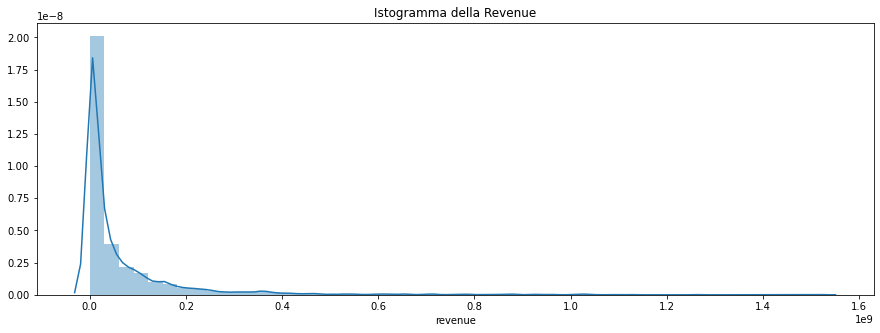

In [37]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(a = train['revenue']).set_title("Istogramma della Revenue") # generazione del grafico

Osserviamo che buona parte dei valori vale 0. 

### Belongs to collection
Nome della collezione a cui il film può appartenenre.

In [38]:
Counter(values_to_list("belongs_to_collection", train)).most_common(15)

[('James Bond Collection', 16),
 ('Friday the 13th Collection', 7),
 ('The Pink Panther (Original) Collection', 6),
 ('Police Academy Collection', 5),
 ('Pokémon Collection', 5),
 ('Rocky Collection', 4),
 ('Ice Age Collection', 4),
 ('The Fast and the Furious Collection', 4),
 ('Rambo Collection', 4),
 ('Alien Collection', 4),
 ('Resident Evil Collection', 4),
 ("Child's Play Collection", 4),
 ('Transformers Collection', 4),
 ('Paranormal Activity Collection', 4),
 ('Rush Hour Collection', 3)]

### Budget
Budget del film.

Text(0.5, 1.0, 'Istogramma del budget')

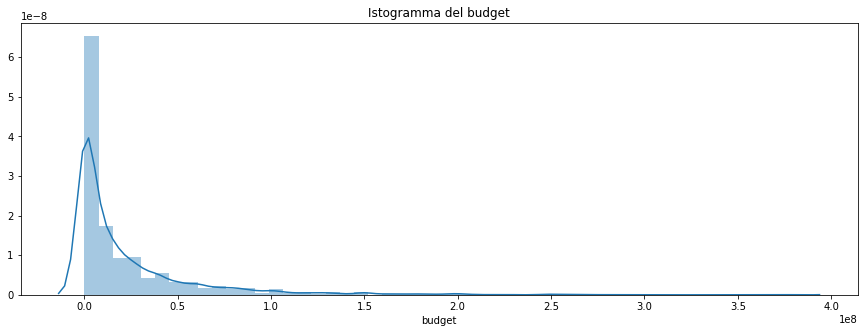

In [39]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(a = train['budget']).set_title("Istogramma del budget") # generazione del grafico

### Genres
Generi del film.

In [40]:
Counter(values_to_list("genres", train)).most_common(15)

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100)]

### Popularity
Popolarità del film

Text(0.5, 1.0, 'Istogramma della Revenue')

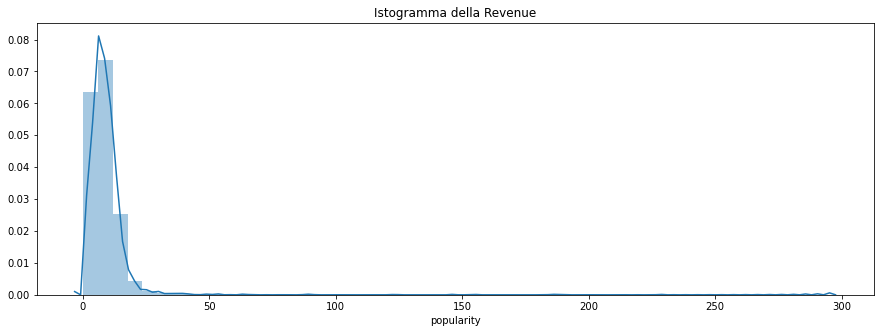

In [41]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(a = train['popularity']).set_title("Istogramma della Revenue") # generazione del grafico

### Production Companies
Casa produttrice del film.

In [42]:
Counter(values_to_list("production_companies", train)).most_common(15)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40)]

### Production Countries
Nazionalità del film.

In [43]:
Counter(values_to_list("production_countries", train)).most_common(15)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23)]

### Release Date
Data di uscita del film.  
La data, nel dataframe, è in formato stringa: poco utile.  
Vogliamo **trasformarla in più colonne** indicanti l'anno, il mese, il giorno della settimana e la settimana nell'anno. 

In [44]:
# Coversione della data da tipo stringa a tipo data
train["release_date"] = pd.to_datetime(train["release_date"], errors = "coerce", infer_datetime_format=True)

In [45]:
# Splitting della data in Anno, Mese, N° settimana e Giorno della settimana.
train["year_release"] = train["release_date"].dt.year
train["month_release"] = train["release_date"].dt.month
train["week_of_year_release"] = train["release_date"].dt.weekofyear
train["day_of_week_release"] = train["release_date"].dt.weekday

In [46]:
# Rimozione della features modificata
train.drop(labels=["release_date"], axis='columns', inplace=True)

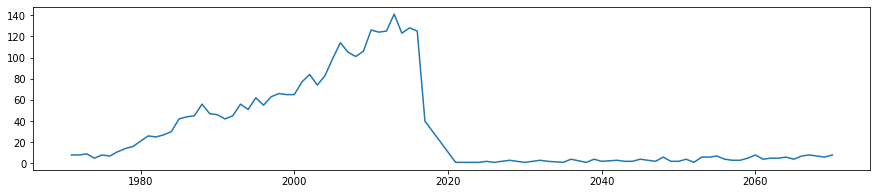

In [47]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(train.groupby("year_release").size())

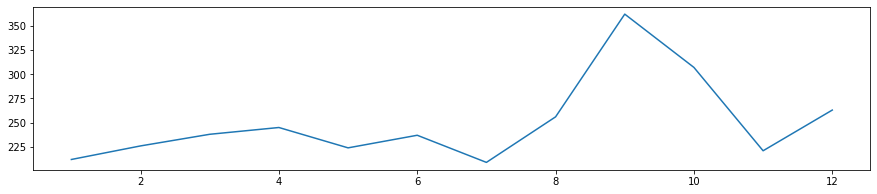

In [48]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(train.groupby("month_release").size())

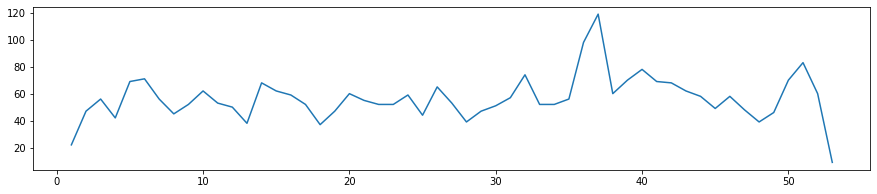

In [49]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(train.groupby("week_of_year_release").size())

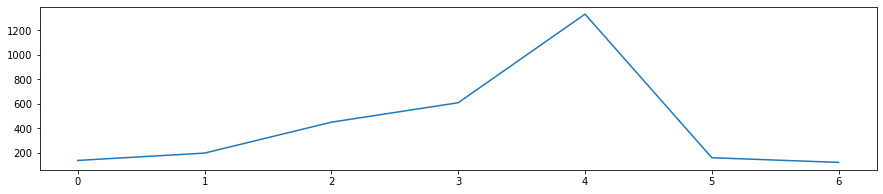

In [50]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(train.groupby("day_of_week_release").size())

### Runtime
Durata del film.

Text(0.5, 1.0, 'Istogramma della Revenue')

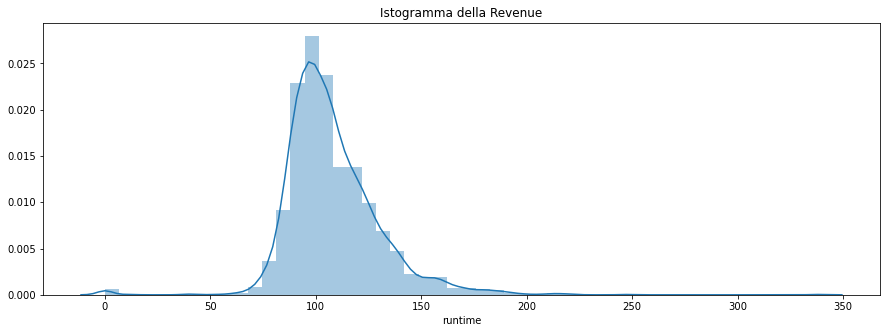

In [51]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(a = train['runtime']).set_title("Istogramma della Revenue")
# generazione del grafico

### Spoken languages
Lingue in cui il film è stato tradotto.

In [52]:
Counter(values_to_list("spoken_languages", train)).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

### Keywords
Parole chiave per il film.

In [53]:
Counter(values_to_list("keywords", train)).most_common(15)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66)]